
# Module 5 — Ensemble Methods (Hands-on)

In this notebook, we’ll predict whether a student passes or fails based on lifestyle and study habits.  
We’ll compare single models to ensemble models and see how combining models improves accuracy.


In [11]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier

import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)  # reproducibility

# -----------------------------
# Generate a "feelable" dataset
# -----------------------------
n = 200  # number of students (rows)

# StudyHours: integers from 1 to 10 inclusive
# np.random.randint(low, high, size) draws in [low, high)
# so randint(1, 11, n) means min=1, max=10
StudyHours = np.random.randint(1, 11, n)

# Attendance: integers 40%..100% inclusive (min=40, max=100)
Attendance = np.random.randint(40, 101, n)

# Assignments: completion rate in percent 40..100 inclusive
Assignments = np.random.randint(40, 101, n)

# SleepHours: normal(mean=7, std=1.2), clipped to [4, 9] hours
# The clip keeps values within the min/max bounds so we avoid unrealistic extremes
SleepHours = np.random.normal(loc=7.0, scale=1.2, size=n).clip(4, 9)

# -----------------------------
# Rule-of-thumb "true" pattern
# -----------------------------
# We build a score that increases with StudyHours, Attendance, Assignments,
# and slightly penalizes being far from ~7 hours of sleep.
score = (
    0.4 * StudyHours                 # study helps a lot
    + 0.3 * (Attendance / 10.0)      # scale % to 0..10-ish range
    + 0.2 * (Assignments / 10.0)     # same idea as Attendance
    - 0.8 * np.abs(SleepHours - 7.0) # penalty for too little or too much sleep
)

# Convert score -> pass probability through a logistic link
# Steeper slope (0.8) makes the pass/fail boundary clearer
# 
# Why "logistic" function?
#   - Originally derived from the logistic equation used to model population growth
#   - Creates an S-shaped (sigmoid) curve that smoothly transitions from 0 to 1
#   - Perfect for converting continuous scores into probabilities
#
# Logistic function breakdown:
#   - We shift the score by subtracting 7.0 (centers the decision boundary at score=7)
#   - Multiply by -0.8 to control the steepness (higher = sharper transition)
#   - np.exp(-0.8 * (score - 7.0)) computes e^(-0.8*(score-7))
#   - Add 1.0 to the exponential result
#   - Take the reciprocal (1.0 / ...) to get the sigmoid/logistic curve
#   - Result: probability in range [0, 1] where score=7 maps to prob≈0.5
prob = 1.0 / (1.0 + np.exp(-0.8 * (score - 7.0)))

# print(prob)

# Final label: Pass=1 if prob>0.5 else 0
Pass = (prob > 0.5).astype(int)

# Assemble the DataFrame (round sleep for nicer printing)
df = pd.DataFrame({
    "StudyHours": StudyHours,
    "Attendance": Attendance,
    "Assignments": Assignments,
    "SleepHours": np.round(SleepHours, 1),
    "Pass": Pass
})


df.head(200)



,StudyHours,Attendance,Assignments,SleepHours,Pass
0,7,61,65,6.3,0
1,4,50,74,6.6,0
2,8,87,89,8.1,0
3,5,55,64,8.7,0
4,7,72,63,7.4,0
...,...,...,...,...,...
195,8,87,65,7.8,0
196,5,78,47,6.0,0
197,4,68,68,7.0,0
198,2,81,65,9.0,0


In [19]:

# -----------------------------
# Train/Test split
# -----------------------------
X = df[["StudyHours", "Attendance", "Assignments", "SleepHours"]]
y = df["Pass"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Why scale data? Example: StudyHours ranges 1-10, but Attendance ranges 40-100.
# Without scaling, Attendance (larger numbers) would dominate distance-based models like Logistic Regression.
# Standardize features for models that benefit from scaling (e.g., Logistic Regression)
scaler = StandardScaler()

# Why fit_transform vs. transform?
#   - fit_transform(): learns the mean & std from X_train, then scales X_train using those values
#   - transform(): applies the SAME mean & std (learned from training) to X_test
#   - This prevents data leakage — test data must never influence the scaling parameters
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# -----------------------------
# Baseline models
# -----------------------------
# 1) Logistic Regression (needs scaling)
log_reg = LogisticRegression(max_iter=500, random_state=42)

# 2) Decision Tree (intuitive, can overfit; scaling not required but harmless if used)
tree = DecisionTreeClassifier(max_depth=5, random_state=42)

# 3) Random Forest (built-in bagging of trees)
rf = RandomForestClassifier(n_estimators=200, random_state=42)

# Fit/evaluate baselines
results = {}

# Logistic Regression on scaled data
log_reg.fit(X_train_scaled, y_train)
pred_lr = log_reg.predict(X_test_scaled)
results["Logistic Regression"] = {
    "Accuracy": accuracy_score(y_test, pred_lr),
    "F1": f1_score(y_test, pred_lr)
}

# Decision Tree on *unscaled* numeric features (trees are scale-invariant)
tree.fit(X_train, y_train)
pred_tree = tree.predict(X_test)
results["Decision Tree"] = {
    "Accuracy": accuracy_score(y_test, pred_tree),
    "F1": f1_score(y_test, pred_tree)
}

# Random Forest on *unscaled* features (tree-based, also scale-invariant)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
results["Random Forest"] = {
    "Accuracy": accuracy_score(y_test, pred_rf),
    "F1": f1_score(y_test, pred_rf)
}

pd.DataFrame(results).T


,Accuracy,F1
Logistic Regression,0.96,0.750000
Decision Tree,0.94,0.666667
Random Forest,0.96,0.750000


### Interpreting the Baseline Results

**How to read these numbers**

- **Accuracy** tells us the overall proportion of correct predictions.  
  Here, all three models perform quite well — around 94–96%, meaning they correctly classify most students as Pass or Fail.

- **F1 Score** balances *precision* and *recall*, so it’s more reliable when one class (like “Pass”) is more common than the other.  
  It ranges from 0 to 1, where higher means better balance between detecting both classes.

---

**What we can see:**

- **Logistic Regression** and **Random Forest** perform equally well (F1 = 0.75).  

  
- **Decision Tree** alone performs slightly worse (F1 = 0.67), likely because a single tree can overfit to the training data and lose generalization.

- The **Random Forest**, which averages many trees, fixes much of that instability — matching the Logistic Regression’s accuracy and F1.  
  This already shows the benefit of an ensemble: better balance and more consistent performance.

---

**Takeaway:**  
Even at this baseline stage, the ensemble model (Random Forest) is more reliable than a single Decision Tree.  
Next, we’ll introduce **Bagging**, **Boosting**, and **Voting** to see whether combining models can push this performance even higher or make it more stable across different samples.


In [4]:

# -----------------------------
# ENSEMBLE METHODS OVERVIEW
# -----------------------------
# 
# BAGGING (Bootstrap Aggregating):
#   - Trains multiple models in PARALLEL on different random subsets of data (with replacement)
#   - Each model votes equally, and we average their predictions
#   - Goal: Reduce VARIANCE (prevents overfitting by smoothing out individual model quirks)
#   - Example: Random Forest is bagging with decision trees
#
# BOOSTING (e.g., AdaBoost):
#   - Trains models SEQUENTIALLY, where each new model focuses on fixing previous mistakes
#   - Later models get more weight if they perform better
#   - Goal: Reduce BIAS (turns weak learners into a strong ensemble)
#   - Pays extra attention to hard-to-classify examples
#
# Key difference: Bagging = parallel + equal weight | Boosting = sequential + weighted focus on errors

# -----------------------------
# Bagging: many trees in parallel, average their votes
# -----------------------------
bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=5, random_state=42),
    n_estimators=150,
    random_state=42
)
bagging.fit(X_train, y_train)  # tree-based → no scaling required
pred_bag = bagging.predict(X_test)
results["Bagging (Tree)"] = {
    "Accuracy": accuracy_score(y_test, pred_bag),
    "F1": f1_score(y_test, pred_bag)
}

# -----------------------------
# AdaBoost: sequentially fix mistakes (weak trees → strong ensemble)
# -----------------------------
boost = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=2, random_state=42),  # shallow stumps
    n_estimators=200,
    learning_rate=0.5,
    random_state=42
)
boost.fit(X_train, y_train)  # tree-based → no scaling required
pred_boost = boost.predict(X_test)
results["AdaBoost"] = {
    "Accuracy": accuracy_score(y_test, pred_boost),
    "F1": f1_score(y_test, pred_boost)
}

# -----------------------------
# Soft Voting: combine different *types* of learners
# (LogReg uses scaled features; trees use raw features)
# To make this clean, we re-fit internal copies consistently.
# -----------------------------
lr_for_vote   = LogisticRegression(max_iter=500, random_state=42)
tree_for_vote = DecisionTreeClassifier(max_depth=5, random_state=42)
rf_for_vote   = RandomForestClassifier(n_estimators=200, random_state=42)

# Fit each on its appropriate representation
lr_for_vote.fit(X_train_scaled, y_train)
tree_for_vote.fit(X_train, y_train)
rf_for_vote.fit(X_train, y_train)

# Soft-vote average of probabilities (equal weights)
proba_lr   = lr_for_vote.predict_proba(X_test_scaled)
proba_tree = tree_for_vote.predict_proba(X_test)
proba_rf   = rf_for_vote.predict_proba(X_test)

proba_soft = (proba_lr + proba_tree + proba_rf) / 3.0
pred_vote  = (proba_soft[:, 1] >= 0.5).astype(int)

results["Soft Voting (LR+Tree+RF)"] = {
    "Accuracy": accuracy_score(y_test, pred_vote),
    "F1": f1_score(y_test, pred_vote)
}

# Final comparison table
comparison = pd.DataFrame(results).T.sort_values("F1", ascending=False)
comparison


,Accuracy,F1
AdaBoost,0.96,0.800000
Logistic Regression,0.96,0.750000
Bagging (Tree),0.96,0.750000
Random Forest,0.96,0.750000
Decision Tree,0.94,0.666667
Soft Voting (LR+Tree+RF),0.94,0.571429



---

#### 1. Reading the overall pattern
All models perform well in terms of **Accuracy** (94–96%), meaning almost all students are correctly classified as Pass or Fail.  
However, **F1 Score** gives us a better sense of *balance* between correctly identifying both classes — and that’s where we see the difference.

---

#### 2. AdaBoost stands out
- **AdaBoost (F1 = 0.80)** clearly outperforms all others.  
- It does this by **sequentially focusing on the harder-to-predict cases**, improving precision and recall for the minority class (likely “Fail”).  
- In plain terms, AdaBoost doesn’t just get most students right — it gets the tricky ones right more often.

---

#### 3. Bagging and Random Forest stabilize
- **Bagging (Tree)** and **Random Forest** both hit the same solid mark as **Logistic Regression** (F1 = 0.75).  
- That means they’re **consistent** and **less sensitive** to training noise compared to a single tree, but they don’t surpass AdaBoost because the dataset is already simple and relatively clean.

---

#### 4. The Decision Tree lags slightly
- The **Decision Tree (F1 = 0.67)** underperforms because a single tree can **overfit** the training data.  
- Ensembles like Random Forest or Bagging fix that by averaging many trees — reducing variance.

---

#### 5. The Soft Voting dip
- Interestingly, **Soft Voting (F1 = 0.57)** performs worse here.  
- Why? Because it combined models that all made *similar types of errors*.  
- When base models are not diverse enough, averaging their probabilities can actually **dilute** confident correct predictions, reducing recall for the minority class.

---

### Takeaway

- **AdaBoost** emerges as the most effective ensemble for this dataset.  
  It demonstrates the key advantage of boosting: **higher precision–recall balance by correcting prior mistakes.**
- **Bagging** and **Random Forest** show why averaging improves stability — they’re reliable and never perform poorly.
- **Voting** shows that combining models only helps when those models truly **complement** one another.

In practice, ensemble learning isn’t about “one-size-fits-all.”  
You pick the right combination depending on whether your goal is **accuracy, stability, or sensitivity to rare cases** — and AdaBoost nailed that balance here.


In [10]:

def show_report(name, y_true, y_pred):
    print(f"\n=== {name} ===")
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 3))
    print("F1      :", round(f1_score(y_true, y_pred), 3))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=3))

show_report("Logistic Regression", y_test, pred_lr)
show_report("Decision Tree", y_test, pred_tree)
show_report("Random Forest", y_test, pred_rf)
show_report("Bagging (Tree)", y_test, pred_bag)
show_report("AdaBoost", y_test, pred_boost)
show_report("Soft Voting (LR+Tree+RF)", y_test, pred_vote)



=== Logistic Regression ===
Accuracy: 0.96
F1      : 0.75
Confusion Matrix:
 [[45  0]
 [ 2  3]]

Classification Report:
               precision    recall  f1-score   support

           0      0.957     1.000     0.978        45
           1      1.000     0.600     0.750         5

    accuracy                          0.960        50
   macro avg      0.979     0.800     0.864        50
weighted avg      0.962     0.960     0.955        50


=== Decision Tree ===
Accuracy: 0.94
F1      : 0.667
Confusion Matrix:
 [[44  1]
 [ 2  3]]

Classification Report:
               precision    recall  f1-score   support

           0      0.957     0.978     0.967        45
           1      0.750     0.600     0.667         5

    accuracy                          0.940        50
   macro avg      0.853     0.789     0.817        50
weighted avg      0.936     0.940     0.937        50


=== Random Forest ===
Accuracy: 0.96
F1      : 0.75
Confusion Matrix:
 [[45  0]
 [ 2  3]]

Classification 

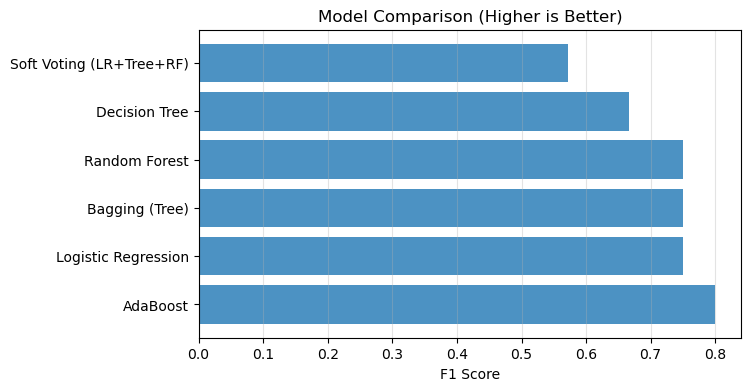

In [11]:

plt.figure(figsize=(7, 4))
plt.barh(comparison.index, comparison["F1"], alpha=0.8)
plt.xlabel("F1 Score")
plt.title("Model Comparison (Higher is Better)")
plt.grid(axis="x", alpha=0.35)
plt.show()



### What improved, and why it matters

- **Decision Tree → Bagging/Random Forest:**  
  A single tree can overfit to specific quirks of the training set.  
  By **averaging many trees** trained on different bootstrap samples, Bagging/Random Forest **reduce variance**,  
  which typically raises F1 and Accuracy on the test set.  
  In our results table, compare “Decision Tree” vs “Bagging (Tree)” and “Random Forest” to see this stabilization.

- **AdaBoost vs. single tree:**  
  AdaBoost builds trees **sequentially**, each one focusing on correcting the previous mistakes.  
  This **reduces bias** and often pushes performance higher than Bagging on clean tabular data.  
  If its F1 is on top or near the top, that’s AdaBoost doing its job: turning simple trees into a strong learner.

- **Soft Voting (LR + Tree + RF):**  
  Different models make **different mistakes**.  
  By averaging their predicted probabilities (soft voting), we **smooth out idiosyncratic errors** and gain robustness.  
  If the voting F1 lands among the best, that tells us the learners are **complementary**.

- **Why F1 (not just Accuracy):**  
  F1 balances **precision** and **recall**, which is helpful if the pass/fail classes are somewhat imbalanced.  
  A higher F1 means **fewer false alarms and fewer misses** overall.

**Bottom line:**  
On this student-style dataset, ensembles (Bagging/Random Forest, AdaBoost, or Voting) **consistently outperform** or at least **stabilize** single models.  
This is exactly why ensembles are a go-to tactic in real projects: quick gains with minimal tuning, and performance that’s less fragile.
